In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as img
import netCDF4 as nc
import glob
import numpy as np
import math
from scipy import signal, interpolate, fftpack
import time
import pandas as pd

In [2]:
#Load a list of image locations
imList = glob.glob('../../ShawnImages/shawn_sonar_images/images_processed/*.png')
#The first 9 images of this dataset aren't useful
imRange = range(9, len(imList))

In [3]:
#Estimated dimensions of one pixel
dx = 0.0217
dy = 0.0217

#Create x and y dimensions, as well as edgelength of a subimage
x = np.arange(-650*dx, 650*dx, dx)
y = np.arange(-650*dy, 650*dy, dy)
squareEdgeLength = 256*dx

In [4]:
def subImageInterp(x, y, z, m, n):
    #This function creates and interpolates over the subimage region
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     m: number of points in the x direction, ideally a power of 2
    #     n: number of points in the y direction, ideally a power of 2
    #Output:
    #     xInterp: x-coordinates of the interpolated grid
    #     yInterp: y-coordinates of the interpolated grid
    #     zInterp: Interpolated z values
    
    #Define the center
    xCenter = 0
    yCenter = -5-squareEdgeLength/2.
    
    #Define the 4 corners
    xSquareRange = [xCenter - squareEdgeLength/2., xCenter + squareEdgeLength/2.]
    ySquareRange = [yCenter - squareEdgeLength/2., yCenter + squareEdgeLength/2.]
    
    #Get the datapoints that exist within the subimage
    xMask = np.logical_and(x > xSquareRange[0], x < xSquareRange[1])
    yMask = np.logical_and(y > ySquareRange[0], y < ySquareRange[1])
      
    xReal = x[xMask]
    yReal = y[yMask]
    zReal = z[np.ix_(xMask, yMask)]
        
    #Create the region to interpolate over
    xInterp = np.arange(xSquareRange[0], xSquareRange[1], dx)
    yInterp = np.arange(ySquareRange[0], ySquareRange[1], dy)
    
    #Standardize the size of the regions
    xInterp = xInterp[0:m]
    yInterp = yInterp[0:n]

    #Make the x and y arrays 2-dimensional
    xInterpGrid, yInterpGrid = np.meshgrid(xInterp, yInterp)

    #Reshape the data for the interpolation method
    mTemp = np.size(xReal)
    nTemp = np.size(yReal)
        
    xReal, yReal = np.meshgrid(xReal, yReal)
        
    xReal = xReal.reshape(mTemp*nTemp)
    yReal = yReal.reshape(mTemp*nTemp)
    zReal = zReal.reshape(mTemp*nTemp)
        
    #Perform a scattered interpolant
    zInterp = interpolate.griddata((xReal, yReal), zReal,
                                    (xInterpGrid, yInterpGrid), method='cubic')
        
    #Remove NaNs
    zInterp[np.isnan(zInterp)] = 0
    
    return xInterp, yInterp, zInterp
    
    
    
    
def spectrum(x, y, z, dx, dy, m, n):
    #Return a power and associated wavenumbers in the x and y direction
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     dx: step size in the x direction
    #     dy: step size in the y direction
    #     m: number of points in the x direction, ideally a power of 2
    #     n: number of points in the y direction, ideally a power of 2
    #Output:
    #     pZ: power estimate of the fft, pZ = F(kx, ky)
    #     kx: wavenumber in the x direction
    #     ky: wavenumber in the y direction
    
    #First step is to remove a 2nd degree polynomial
    yTrend = np.polyfit(y, z, 2)
    
    xGrid, yGrid = np.meshgrid(x, y)
    
    z = z - np.polyval(yTrend, yGrid)
    
    z = z.transpose()
    
    xTrend = np.polyfit(x, z, 2)
        
    z = z - np.polyval(xTrend, xGrid.transpose())
    
    z = z.transpose()
    
    #Perform the fft
    fftZ = fftpack.fft2(z)
    
    F=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]])
    F=F/F.sum()
    
    F = fftpack.fft2(F, shape=fftZ.shape)
    
    fftZ = fftZ*F
    
    #Estimate power
    pZ = abs(fftZ)**2
    
    pZ[[1, 2, -1], [1, 2 , -1]] = 0
    
    if m%2 == 0:
        pZ[int(m/2+1), :] = 0
    if n%2 == 0:
        pZ[:, int(n/2+1)] = 0
    
    pZ = np.fft.fftshift(pZ)
    
    #Estimate wavenumbers
    xRange = list(range(0, m))
    kx = [((1/2+val/m)%1)-1/2 for val in xRange]
    kx = [val * 2 * math.pi / dx for val in kx]
    kx = np.fft.fftshift(kx)

    yRange = list(range(0, n))
    ky = [((1/2+val/n)%1)-1/2 for val in yRange]
    ky = [val * 2 * math.pi / dy for val in ky]
    ky = np.fft.fftshift(ky)
    
    return pZ, kx, ky
    
    
    

def findRipple(x, y, z):
    #Take ripple image data and return a ripple orientation and wavelength
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     hgt: height of the sonar
    #Output:
    #     theta: ripple orientation
    #     wavelength: ripple wavelength
    
    
    #Define parameters
    
    rot = 0
    north = 90 
    imgRange = 1
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    maxRange = imgRange
    
    sizeX, sizeY = np.shape(z)
    
    imgCenterX = x[int(sizeX/2)]
    imgCenterY = y[int(sizeY/2)]
    
    #Number of points for FFT
    
    m = 256
    n = 256
    
    #FFT is performed on a collection of subimages
    squareEdgeLength = max(m*dx, n*dy)

    #Create the subimage
    xInterp, yInterp, zInterp = subImageInterp(x, y, z, m, n)
    
    #Perform the fft
    pZ, kx, ky = spectrum(xInterp, yInterp, zInterp, dx, dy, m, n)
    
    #Remove low falues
    xMask = abs(kx) <= 3.3
    yMask = abs(ky) <= 3.3
    
    pZ[np.ix_(xMask, yMask)] = 0
    
    
    #Get max wavenumber values
    kx, ky = np.meshgrid(kx, ky)
    
    KX = kx[pZ == pZ.max()]
    KY = ky[pZ == pZ.max()]
    
    #If there are multiple points, use the first one
    if type(KX) == np.ndarray:
        KX = KX[0]
        KY = KY[0]
    
    #Calculate the orientation
    theta=math.atan(KY/KX)*180/math.pi
    theta=-(theta-90)
    theta=theta+90
    if theta < 0:
        theta += 360
    if theta >= 180:
        theta -= 180
    
    #Calculate the wavelength
    wavelength = 2*math.pi/math.sqrt(KX**2 + KY**2)
    
    return theta, wavelength

In [16]:
#Simple smoothing function using a flat window.
def smooth(x, winLength):
    w = np.ones(winLength)
    return signal.fftconvolve(x, w/w.sum(), mode='same')

In [130]:
transect = np.arange(0, 250, 5)
m = 256; n = 256
ni = 250

patch = np.zeros([m, n, ni])

#Create all of the patches

for i in range(ni):
    image = np.flip(img.imread(imList[imRange[i]]), 0)
    xInterp, yInterp, patch[:, :, i] = subImageInterp(x, y, image, m, n)

The MATLAB code uses a lot of array operations unique to MATLAB, so the code may need to be fundamentally restructured.

In [146]:
migr = np.zeros((len(transect), ni-1))

for i in range(len(transect)):
    #The MATLAB code uses imfilter, it appears to be smoothing over the time axis with a mean filter
    tran = patch[np.array([i]*5)+np.array(range(5)), :, :].mean(axis=0)
    tran = signal.fftconvolve(tran, np.ones((1, 5))/5, mode='same')
    
    #Get upper- and lower-bounds for detrending
    lb = smooth(np.percentile(tran, 20, axis=1), 20)http://localhost:8888/notebooks/PythonScripts/notebook/TraykovskiTransectBedloadMethod.ipynb#
    ub = smooth(np.percentile(tran, 80, axis=1), 20)
    
    #Detrend using upper- and lower-bound
    tran = (tran.transpose() - np.array([list(lb)]*ni))/np.array([list(lb-ub)]*ni)
    tran = tran.transpose()-[tran.mean(axis=1)]*m
    zc = np.logical_and(tran[0:-2,:]*tran[1:-1, :]<0, tran[0:-2,:]-tran[1:-1, :]<0)
    
    #Get distance traveled per unit time
    for j in range(ni-1):
        #Get difference in time in hours between images for two transects
        dt = 1
        f1 = np.squeeze(np.where(zc[:, j]))
        f2 = np.squeeze(np.where(zc[:, j+dt]))
        #Certain zero-crossings appear as empty lists according to MATLAB code
        #this fix keeps moving forward in time until a list is found
        while not list(f2):
            dt += 1
            f2 = np.where(zc[:, j+dt])
        
        #Calculate distance between the two closest zero-crossings
        dist = [0]*len(f1)
        for k in range(len(f1)):
            ind = [np.argmin(abs(f2-f1[k]))]
            ind = ind[0]
            dist[k] = f2[ind] - f1[k]
        dist = [float('Nan') if abs(a) > 20 else a for a in dist]
        
        #Convert distance to migrate rate
        migr[i, j] = np.nanmean(dist)/dt

#Calculate total migration
totalMigrate = np.nanmean(migr, axis=0)

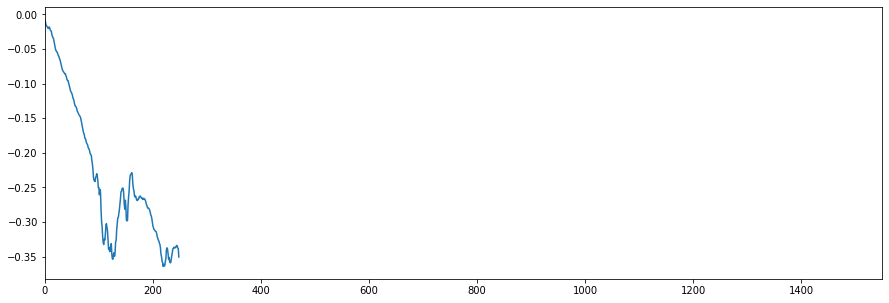

In [150]:
plt.figure(figsize=[15, 5])
plt.plot(np.cumsum(totalMigrate*dx))
plt.xlim(0, len(imRange))
plt.show()

In [140]:
#Test case

#The MATLAB code uses imfilter, it appears to be smoothing over the time axis with a mean filter
tran = patch[:, np.array([i]*5)+np.array(range(5)), :].mean(axis=1)
tran = signal.fftconvolve(tran, np.ones((1, 5))/5, mode='same')

#Get upper- and lower-bounds for detrending
lb = smooth(np.percentile(tran, 20, axis=1), 20)
ub = smooth(np.percentile(tran, 80, axis=1), 20)

#Detrend using upper- and lower-bound
tran = (tran.transpose() - np.array([list(lb)]*ni))/np.array([list(lb-ub)]*ni)
tran = tran.transpose()-[tran.mean(axis=1)]*m
zc = np.logical_and(tran[0:-2,:]*tran[1:-1, :]<0, tran[0:-2,:]-tran[1:-1, :]<0)

#get distance traveled for each time value
migrTest = [0]*(ni-1)

for j in range(ni-1):
    dt = 1
    f1 = np.squeeze(np.where(zc[:, j]))
    f2 = np.squeeze(np.where(zc[:, j+dt]))
    while not list(f2):
        dt += 1
        f2 = np.where(zc[:, j+dt])
        
    dist = [0]*len(f1)
    for k in range(len(f1)):
        ind = [np.argmin(abs(f2-f1[k]))]
        ind = ind[0]
        dist[k] = f2[ind] - f1[k]
    dist = [float('Nan') if abs(a) > 20 else a for a in dist]
        
    migrTest[k] = np.nanmean(dist)/dt

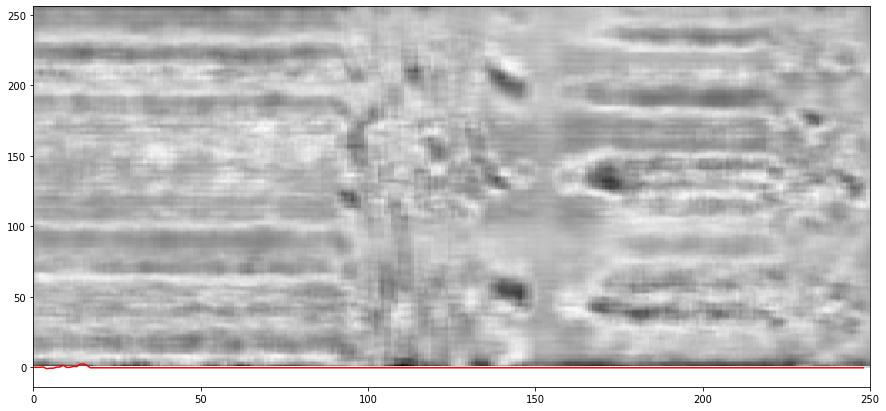

In [144]:
plt.figure(figsize=[15, 7])
plt.pcolor(tran, cmap='gray')
plt.plot(np.cumsum(migrTest), 'red')
plt.show()